[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YuichiKZ/pytorch_gan/blob/main/QA/QA20230506_SNGAN_FLOWER_GRAYSCALE_pytorch.ipynb)

# SNGAN(モノクロ画像)のノートブック
- このノートブックではPyTorchによるSpectral Normalization GANネットワークの実装と学習を行い花のモノクロ画像生成を体験します。

# 学習目標
- 画像を生成するGenerator(生成器)のネットワーク構造を理解する
- 画像を識別するDiscriminator(識別器)のネットワーク構造を理解する
- GANの損失関数とニューラルネットワークの学習の流れを理解する
- SNGANでモノクロ画像の生成を行う


# GPU確認

In [ ]:
!nvidia-smi

Sat May  6 10:59:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PyTorch インポート & バージョン確認

In [1]:
import torch
import torchvision
# バージョンの確認
print(torch.__version__) 
print(torchvision.__version__) 

2.0.0+cu118
0.15.1+cu118


# DCGAN実装

## パッケージインポート

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchsummary

## パラメータ設定

In [20]:
batch_size=50
z_dim = 100 #ノイズ次元
g_dim = 128 
d_dim = 128 
num_epochs = 300 #エポック数
lr = 0.0005 #学習率
beta1 = 0.5
out_dir = './result_3-DCGAN_FLOWER'
loss_display_interval = 1200

# 保存先ディレクトリを作成
try:
    os.makedirs(out_dir, exist_ok=True)
except Exception as error: 
    print(error)

# 乱数のシード（種）を固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

##データセット定義

In [4]:
# データセットのダウンロード
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz -P ./flower/

--2023-05-06 12:04:57--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.168.181, 54.231.202.184, 54.231.197.144, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.168.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘./flower/flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  68.6MB/s    in 5.3s    

2023-05-06 12:05:02 (62.3 MB/s) - ‘./flower/flower_data.tar.gz’ saved [344873452/344873452]



In [ ]:
# データセット（画像）の解凍
!tar -zxvf ./flower/flower_data.tar.gz -C ./flower

(500, 523)


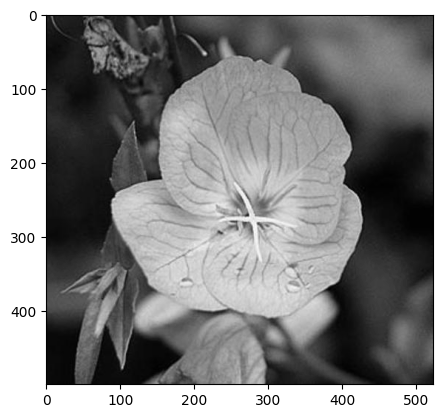

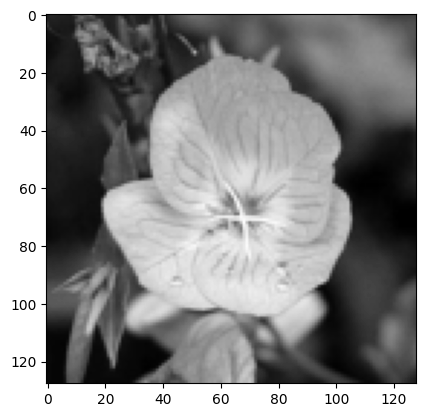

In [6]:
#画像の読み込み
image = "./flower/train/1/image_06734.jpg"
with open(image, 'rb') as f:
    image = Image.open(f)
    image = image.convert('L')
    image.save("grayscale.jpg")
    print(np.array(image).shape)

plt.figure()
plt.imshow(image, cmap = "gray")

# torchvisionのデータ拡張transformsを利用
# 短辺の長さが128となるようにアスペクト比を固定してリサイズ
trans_image = transforms.Resize(128)(image)
# サイズ128でランダムクロップ
trans_image = transforms.RandomCrop(128)(trans_image)

plt.figure()
plt.imshow(trans_image, cmap = "gray")

- `transforms.Compose(transforms)`<br>
複数の Transform を連続して行う Transform を作成
- `transforms.ToTensor()`<br>
PIL Imageまたはnumpy ndarrayをTorch Tensorに変換
- `transforms.Resize(size)`<br>
短辺の長さが size となるようにアスペクト比を固定してリサイズする
- `transforms.RandomCrop()`<br>
ランダムに画像を切り抜くTransform ,幅 size、高さ size となるように切り抜く

- `transforms.Normalize((mean,...),(std,...))`<br>
各チャンネルに関して標準化を行う<br>
$output[channel] = (input[channel]-mean[channel])/std[channel]$<br>
i.e. <br>
MNISTの場合<br>
チャンネル数: 1(白黒画像)<br>
分布: [0,1]<br>
より
$std=0.5, mean=0.5$とすると
分布は[-1,1]となる。

In [7]:
dataset = dset.ImageFolder('./flower/train',
    transform=transforms.Compose([
    # サイズ128にResize
    transforms.Resize(128),
    # ランダムに画像を切り抜く
    transforms.RandomCrop(128),
    # モノクロ画像化
    transforms.Grayscale(num_output_channels=1),
    # Tensor化
    transforms.ToTensor(),
    # -1～1に値域の変更
    transforms.Normalize((0.5), (0.5))
]))

In [8]:
print(type(dataset))
# 画像配列の確認
dataset[3][0].shape

<class 'torchvision.datasets.folder.ImageFolder'>


torch.Size([1, 128, 128])

In [9]:
# 画像配列の形状確認
dataset[0][0].shape

torch.Size([1, 128, 128])

In [10]:
# 訓練データをセットしたDataLoader作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# 学習に使用するデバイスを指定。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


##ネットワークの定義

### Generatorクラス

In [11]:
class Generator(nn.Module):
    """
    生成器Gのクラス
    """
    def __init__(self, z_dim=100, g_dim=32, nch=1):
        """
        z_dim: 入力ベクトルzの次元
        g_dim: 最終層の入力チャネル数
        nch: 出力画像のチャネル数
        """
        super(Generator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.ConvTranspose2d(z_dim, g_dim * 16, 4, 1, 0),     # 転置畳み込み
                nn.BatchNorm2d(g_dim * 16),                      # バッチノーマライゼーション
                nn.ReLU()                                        # ReLU
            ),  # (B, z_dim, 1, 1) -> (B, g_dim*16, 4, 4)
            'layer1': nn.Sequential(
                nn.ConvTranspose2d(g_dim * 16, g_dim * 8, 4, 2, 1),
                nn.BatchNorm2d(g_dim * 8),
                nn.ReLU()
            ),  # (B, g_dim*16, 4, 4) -> (B, g_dim*8, 8, 8)
            'layer2': nn.Sequential(
                nn.ConvTranspose2d(g_dim * 8, g_dim * 4, 4, 2, 1),
                nn.BatchNorm2d(g_dim * 4),
                nn.ReLU()
            ),  # (B, g_dim*8, 8, 8) -> (B, g_dim*4, 16, 16)

            'layer3': nn.Sequential(
                nn.ConvTranspose2d(g_dim * 4, g_dim * 2, 4, 2, 1),
                nn.BatchNorm2d(g_dim * 2),
                nn.ReLU()
            ),  # (B, g_dim*4, 16, 16) -> (B, g_dim*2, 32, 32)
            'layer4': nn.Sequential(
                nn.ConvTranspose2d(g_dim * 2, g_dim , 4, 2, 1),
                nn.BatchNorm2d(g_dim),
                nn.ReLU()
            ),  # (B, g_dim*2, 32, 32) -> (B, g_dim, 64, 64)
            'layer5': nn.Sequential(
                nn.ConvTranspose2d(g_dim, nch, 4, 2, 1),
                nn.Tanh()
            )   # (B, g_dim, 64, 64) -> (B, nch, 128, 128)
        })

    def forward(self, z):
        """
        順方向の演算
        :param z: 入力ベクトル
        :return: 生成画像
        """
        for layer in self.layers.values():  # self.layersの各層で演算を行う
            z = layer(z)
        return z

### Discriminatorクラス

In [17]:
from torch.nn.utils.spectral_norm import spectral_norm

class Discriminator(nn.Module):
    """
    識別器Dのクラス
    """
    def __init__(self, nch=1, d_dim=32):
        """
        :param nch: 入力画像のチャネル数
        :param d_dim: 先頭層の出力チャネル数
        """
        super(Discriminator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(nch, d_dim, 4, 2, 1),     # 畳み込み
                nn.LeakyReLU(negative_slope=0.2)    # leaky ReLU関数
            ),  # (B, nch, 128, 128) -> (B, d_dim, 64, 64)
            'layer1': nn.Sequential(
                spectral_norm(nn.Conv2d(d_dim, d_dim * 2, 4, 2, 1)),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, d_dim, 64, 64) -> (B, d_dim*2, 32, 32)
            'layer2': nn.Sequential(
                spectral_norm(nn.Conv2d(d_dim * 2, d_dim * 4, 4, 2, 1)),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, d_dim*2, 32, 32) -> (B, d_dim*4, 16,16)
            'layer3': nn.Sequential(
                spectral_norm(nn.Conv2d(d_dim * 4, d_dim * 8, 4, 2, 1)),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, d_dim*4, 16, 16) -> (B, d_dim*8, 8, 8)
            'layer4': nn.Sequential(
                spectral_norm(nn.Conv2d(d_dim * 8, d_dim * 16, 4, 2, 1)),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, d_dim*8, 8, 8) -> (B, d_dim*16, 4, 4)
            'layer5': nn.Sequential(
                nn.Conv2d(d_dim * 16, 1, 4, 1, 0),
                nn.Sigmoid()
            )
            # (B, d_dim*16, 4, 4) -> (B, 1, 1, 1)
        })

    def forward(self, x):
        """
        順方向の演算
        :param x: 本物画像あるいは生成画像
        :return: 識別信号
        """
        for layer in self.layers.values():  # self.layersの各層で演算を行う
            x = layer(x)
        return x.squeeze()     # Tensorの形状を(B)に変更して戻り値とする

### 重み初期化関数

In [18]:
def weights_init(m):
    """
    ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
    :param m: ニューラルネットワークを構成する層
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:            # 畳み込み層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:     # バッチノーマライゼーションの場合
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### 生成器Gのインスタンス生成と重み初期化

In [21]:
# 生成器G　インスタンス化, GPU上に転送
G = Generator(z_dim=z_dim, g_dim=g_dim).to(device)
G.apply(weights_init)    # weights_init関数で初期化

Generator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer1): Sequential(
      (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer4): Sequential(
      (0): ConvTranspose2d(25

### 生成器のTensor形状確認

In [15]:
# 生成器GのTensor形状
# torchsummary.summary(network, 入力テンソル形状)
# 入力: 100次元のノイズベクトル
torchsummary.summary(G, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 2048, 4, 4]       3,278,848
       BatchNorm2d-2           [-1, 2048, 4, 4]           4,096
              ReLU-3           [-1, 2048, 4, 4]               0
   ConvTranspose2d-4           [-1, 1024, 8, 8]      33,555,456
       BatchNorm2d-5           [-1, 1024, 8, 8]           2,048
              ReLU-6           [-1, 1024, 8, 8]               0
   ConvTranspose2d-7          [-1, 512, 16, 16]       8,389,120
       BatchNorm2d-8          [-1, 512, 16, 16]           1,024
              ReLU-9          [-1, 512, 16, 16]               0
  ConvTranspose2d-10          [-1, 256, 32, 32]       2,097,408
      BatchNorm2d-11          [-1, 256, 32, 32]             512
             ReLU-12          [-1, 256, 32, 32]               0
  ConvTranspose2d-13          [-1, 128, 64, 64]         524,416
      BatchNorm2d-14          [-1, 128,

### 識別器Dのインスタンス化と重み初期化

In [22]:
# 識別器D　インスタンス化, GPU上に転送
D = Discriminator(d_dim=d_dim).to(device)
D.apply(weights_init)

Discriminator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer4): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer5): Sequential(
      (0): Conv2d(2048, 1, kernel_size=(4, 4), stride=(1, 1))
      (1): Sigmoid()
    )
  )
)

### 識別器のTensor形状確認

In [23]:
# 識別器DのTensor形状
# torchsummary.summary(network, 入力テンソル形状)
# 入力: 1channel*28px*28pxの画像
torchsummary.summary(D, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           2,176
         LeakyReLU-2          [-1, 128, 64, 64]               0
            Conv2d-3          [-1, 256, 32, 32]         524,544
         LeakyReLU-4          [-1, 256, 32, 32]               0
            Conv2d-5          [-1, 512, 16, 16]       2,097,664
         LeakyReLU-6          [-1, 512, 16, 16]               0
            Conv2d-7           [-1, 1024, 8, 8]       8,389,632
         LeakyReLU-8           [-1, 1024, 8, 8]               0
            Conv2d-9           [-1, 2048, 4, 4]      33,556,480
        LeakyReLU-10           [-1, 2048, 4, 4]               0
           Conv2d-11              [-1, 1, 1, 1]          32,769
          Sigmoid-12              [-1, 1, 1, 1]               0
Total params: 44,603,265
Trainable params: 44,603,265
Non-trainable params: 0
-------------------------

## 学習の実行

In [24]:
criterion = nn.BCELoss()    # バイナリークロスエントロピー

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)  

# オプティマイザの用意
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [ ]:
fake_sample_skip=10

G_losses = []
D_losses = []

#最初の画像の保存
fake_image = G(fixed_noise)
vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(out_dir, 0),
                      normalize=True, nrow=10)

# 学習のループ
for epoch in range(num_epochs):
    for n, images in enumerate(dataloader):
        real_image = images[0].to(device)     # 本物画像, GPU上に転送
        sample_size = real_image.size(0)    # 画像枚数
        
        # 標準正規分布(平均0,分散1)からノイズを生成, GPU上に転送
        noise = torch.randn(sample_size, z_dim, 1, 1, device=device)
        # 本物画像に対する正解ラベル:1 , GPU上に転送
        real_target = torch.full((sample_size,), 1., device=device)
        # 生成画像に対する正解ラベル:0 , GPU上に転送
        fake_target = torch.full((sample_size,), 0., device=device)
        
        """
        識別器Dの更新
        """
        D.zero_grad()    # 勾配初期化

        ########################
        # 本物画像に対する損失計算
        ########################
        output = D(real_image) # 識別器Dで本物画像に対する識別信号を出力
        lossD_real = criterion(output, real_target) # 本物画像に対する識別信号の損失値

        ########################
        # 偽物画像に対する損失計算
        ########################
        fake_image = G(noise) # 生成器Gでノイズから生成画像を生成

        output = D(fake_image.detach())  # 識別器Dで本物画像に対する識別信号を出力
        lossD_fake = criterion(output, fake_target)  # 生成画像に対する識別信号の損失値

        ########################
        # 損失計算し,誤差逆伝播
        ########################
        lossD = lossD_real + lossD_fake    # 識別器Dの全体の損失
        lossD.backward()    # 誤差逆伝播
        optimizerD.step()   # Dのパラメーターを更新

        """
        生成器Gの更新
        """
        G.zero_grad()    # 勾配の初期化

        output = D(fake_image)   # 更新した識別器Dで改めて生成画像に対する識別信号を出力
        lossG = criterion(output, real_target)   # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は「1」
        lossG.backward()     # 誤差逆伝播

        optimizerG.step()   # Gのパラメータを更新
        
        """
        DとGのロス表示
        """
        if n % loss_display_interval == 0: 
            print('epoch:[{}/{}],num_images:[{}/{}] Loss_D: {:.3f} Loss_G: {:.3f}'
                  .format(epoch + 1, num_epochs,
                          n + 1, len(dataloader),
                          lossD.item(), lossG.item()))


        if epoch == 0 and n == 0:     # 初回に本物画像を保存する
            vutils.save_image(real_image, '{}/real_samples.png'.format(out_dir),
                              normalize=True, nrow=10)

        # ログ出力用データの保存
        D_losses.append(lossD.item())
        G_losses.append(lossG.item())

    """
    確認用画像の生成
    """
    if (epoch + 1) % fake_sample_skip == 0:    # 10エポックごとに画像を保存
      fake_image = G(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
      vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(out_dir, epoch + 1),
                        normalize=True, nrow=10)

    """
    モデルの保存
    """
    if (epoch + 1) % 100 == 0:   # 100エポックごとにモデルを保存
        torch.save(G.state_dict(), '{}/G_epoch_{}.pth'.format(out_dir, epoch + 1))
        torch.save(D.state_dict(), '{}/D_epoch_{}.pth'.format(out_dir, epoch + 1))

epoch:[1/300],num_images:[1/132] Loss_D: 1.379 Loss_G: 0.213
epoch:[2/300],num_images:[1/132] Loss_D: 1.363 Loss_G: 0.673
epoch:[3/300],num_images:[1/132] Loss_D: 1.388 Loss_G: 0.682
epoch:[4/300],num_images:[1/132] Loss_D: 1.379 Loss_G: 0.796
epoch:[5/300],num_images:[1/132] Loss_D: 1.426 Loss_G: 0.898
epoch:[6/300],num_images:[1/132] Loss_D: 1.328 Loss_G: 0.780
epoch:[7/300],num_images:[1/132] Loss_D: 1.399 Loss_G: 0.690
epoch:[8/300],num_images:[1/132] Loss_D: 1.340 Loss_G: 0.670
epoch:[9/300],num_images:[1/132] Loss_D: 1.370 Loss_G: 0.817
epoch:[10/300],num_images:[1/132] Loss_D: 1.344 Loss_G: 0.867
epoch:[11/300],num_images:[1/132] Loss_D: 1.411 Loss_G: 0.815
epoch:[12/300],num_images:[1/132] Loss_D: 1.357 Loss_G: 0.687
epoch:[13/300],num_images:[1/132] Loss_D: 1.386 Loss_G: 0.698
epoch:[14/300],num_images:[1/132] Loss_D: 1.385 Loss_G: 0.723
epoch:[15/300],num_images:[1/132] Loss_D: 1.350 Loss_G: 0.688
epoch:[16/300],num_images:[1/132] Loss_D: 1.200 Loss_G: 0.783
epoch:[17/300],nu

### 損失ロス

In [ ]:
from matplotlib import pyplot as plt

plt.plot(G_losses, label='Generator_Losses')
plt.plot(D_losses, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')

### 学習過程のアニメーション

In [ ]:
from PIL import Image, ImageDraw

images = []
for epoch in range(0,num_epochs+1,fake_sample_skip):
  img = Image.open('{}/fake_samples_epoch_{:03d}.png'.format(out_dir, epoch))
  images.append(img)

images[0].save('/content/flower_sngan_animation.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

## 重みのロード & 推論

In [ ]:
model_path = '{}/G_epoch_300.pth'.format(out_dir)

# 生成器G　ランダムベクトルから生成画像を作成する
G_infer = Generator(z_dim=z_dim, g_dim=g_dim).to(device)
G_infer.load_state_dict(torch.load(model_path))

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

fake_image = G_infer(fixed_noise)  #確認用の画像を生成する
vutils.save_image(fake_image.detach(), '{}/Generator_sample.png'.format(out_dir),
                  normalize=True, nrow=10)